cuda:0


100%|██████████| 170498071/170498071 [00:01<00:00, 89647571.68it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/50]
Training Loss: 1.434 | Training Accuracy: 47.47%
Test Loss: 1.338 | Test Accuracy: 54.18%
Epoch [2/50]
Training Loss: 0.945 | Training Accuracy: 66.39%
Test Loss: 1.066 | Test Accuracy: 64.62%
Epoch [3/50]
Training Loss: 0.732 | Training Accuracy: 74.12%
Test Loss: 0.698 | Test Accuracy: 76.32%
Epoch [4/50]
Training Loss: 0.606 | Training Accuracy: 78.78%
Test Loss: 0.619 | Test Accuracy: 78.46%
Epoch [5/50]
Training Loss: 0.524 | Training Accuracy: 81.71%
Test Loss: 0.522 | Test Accuracy: 82.52%
Epoch [6/50]
Training Loss: 0.473 | Training Accuracy: 83.56%
Test Loss: 0.537 | Test Accuracy: 82.48%
Epoch [7/50]
Training Loss: 0.432 | Training Accuracy: 85.00%
Test Loss: 0.513 | Test Accuracy: 82.80%
Epoch [8/50]
Training Loss: 0.392 | Training Accuracy: 86.29%
Test Loss: 0.466 | Test Accuracy: 84.64%
Epoch [9/50]
Training Loss: 0.361 | Training Accuracy: 87.52%
Test Loss: 0.637 | Test A

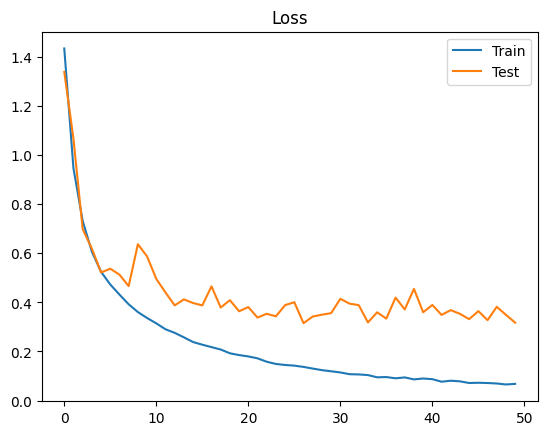

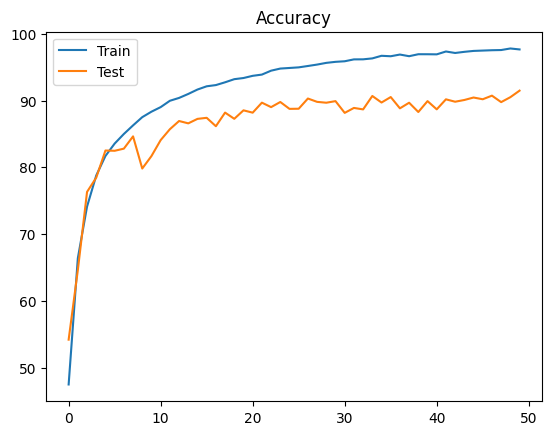

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a tensor and move it to the device
x = torch.randn(3, 3).to(device)

print(x.device)  # will print "cuda" if running on GPU, "cpu" otherwise

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)


# Define model


class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        # Squeeze: Global average pooling across the channel dimension
        s = self.avg_pool(x).flatten(1)

        # Excite: Two fully connected layers with ReLU activation
        s = F.relu(self.fc1(s))
        s = self.fc2(s).sigmoid()

        # Scale: Apply the attention weights
        return x * s.unsqueeze(2).unsqueeze(3)

class SEBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, reduction=16):
        super(SEBasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels * self.expansion, reduction)
        self.conv2 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels * self.expansion)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        residual = self.shortcut(x)

        x = F.relu(self.bn1(self.conv1(x)))
        x = self.se(x)
        x = self.bn2(self.conv2(x))

        return F.relu(x + residual)

class SENet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, reduction=16):
        super(SENet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1, reduction=reduction)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2, reduction=reduction)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2, reduction=reduction)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2, reduction=reduction)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride, reduction):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride, reduction))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = SENet(SEBasicBlock, [2, 2, 2, 2]).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Training loop
num_epochs = 50
train_los = []
train_acc = []
test_los = []
test_acc = []
for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    total = 0
    
    # Train
    model.train()
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        
    train_accuracy = 100 * train_correct / total
    train_loss /= len(trainloader)
    train_acc.append((train_accuracy))
    train_los.append((train_loss))


    # Evaluate on test set
    test_loss = 0.0
    test_correct = 0
    total = 0
    
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            test_correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
            
    test_accuracy = 100 * test_correct / total
    test_loss /= len(testloader)
    test_acc.append((test_accuracy))
    test_los.append((test_loss))    
    # Print stats
    print("Epoch [{}/{}]".format(epoch+1, num_epochs))
    print("Training Loss: {:.3f} | Training Accuracy: {:.2f}%".format(train_loss, train_accuracy))
    print("Test Loss: {:.3f} | Test Accuracy: {:.2f}%".format(test_loss, test_accuracy))

# Save the model
torch.save(model.state_dict(), 'senet_cifar10.pth')

# Plot the loss and accuracy curves
plt.plot(train_los, label='Train')
plt.plot(test_los, label='Test')
plt.title('Loss')
plt.legend()
plt.show()

plt.plot(train_acc, label='Train')
plt.plot(test_acc, label='Test')
plt.title('Accuracy')
plt.legend()
plt.show()

